# Tabular reinforcement learning

Tabular RL is the easiest way to understand the main priciples of this approach in machine learning. Tabular RL assumes that there is a dicrete number of states and and actions.

## Gymnasium environment

To experiment with the RL methods we need to have suitable simulated environments or real robots. The most popular library is Gymnasium (originally OpenAI Gym):

 * https://gymnasium.farama.org/

Gymnasium can be installed via Anaconda:

```bash
 (dataml200-24) $ conda install conda-forge::gymnasium
```

The classic “agent-environment loop” pictured below is simplified representation of reinforcement learning that Gymnasium implements.

<div><img src="pictures/Gymnasium_RL_loop.png" width=400> </div>

### Example environment: FrozenLake

<div>
    <img src="pictures/Gymnasium_FrozenLake.png" width=400>
</div>

More info: https://gymnasium.farama.org/environments/toy_text/frozen_lake/

Initialize FrozenLake

In [49]:
import gymnasium as gym

env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")
env.reset()
print(env.render())

print(f'Action space size: {env.action_space.n} and state space size: {env.observation_space.n}')
print()
print('Discrete actions: 0/left 1/down 2/right 3/up:')


SFFF
FHFH
FFFH
HFFG

Action space size: 4 and state space size: 16

Discrete actions: 0/left 1/down 2/right 3/up:


Let's run one episode of fixed actions in deterministic (non-slippery) and non-deterministic (slippery) versions of the environment.

In [53]:
actions = [2,2,1,1,1,2]

observation, info = env.reset()
print(f'S_0={observation}')
print(env.render())

for num,a in enumerate(actions):
    observation, reward, terminated, truncated, info = env.step(a)
    print(f'S_{num+1}={observation}, r_{num+1}={reward}, terminated={terminated}')
    print(env.render())

    if terminated:
        break

S_0=0

SFFF
FHFH
FFFH
HFFG

S_1=4, r_1=0.0, terminated=False
  (Right)
SFFF
FHFH
FFFH
HFFG

S_2=8, r_2=0.0, terminated=False
  (Right)
SFFF
FHFH
FFFH
HFFG

S_3=9, r_3=0.0, terminated=False
  (Down)
SFFF
FHFH
FFFH
HFFG

S_4=10, r_4=0.0, terminated=False
  (Down)
SFFF
FHFH
FFFH
HFFG

S_5=9, r_5=0.0, terminated=False
  (Down)
SFFF
FHFH
FFFH
HFFG

S_6=10, r_6=0.0, terminated=False
  (Right)
SFFF
FHFH
FFFH
HFFG



## Discrete policy $\pi[s]$

Policy can be represented by a vector that defines the selected action for each state. The manually selected fixed route can be encoded by using random actions for unknown states.

In [38]:
import numpy as np

pi = np.zeros((env.observation_space.n)).astype(int)
pi[0] = 2
pi[1] = 2
pi[2] = 1
pi[6] = 1
pi[10] = 1
pi[14] = 2
print(pi)

[2 2 1 0 0 0 1 0 0 0 1 0 0 0 2 0]


### State-value function $v(s)$

Value function provides the total return obtained by starting a state $s$ and following given policy. More precisely defined as $v_\pi (s)$.

Compute value function $v_\pi(s)$ for deterministic environment. You may re-run and always obtain the same value.

In [55]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")
s, info = env.reset()

gamma = 0.9

G = 0
discount = 1
while True:
    a = pi[s]
    s, reward, terminated, truncated, info = env.step(a)
    G = G+discount*reward
    discount = gamma*discount
    if terminated:
        break
print(G)

0.0


Compute value function $v_\pi(s)$ for deterministic environment. We need to repeat the episode multiple times and use the average return as the expected return. How many episodes are needed to stabilize the estimate (surely depends on the environment)?

In [61]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=False, render_mode="ansi")

N = 500
gamma = 0.9

G_n = [] 
for epi in range(N):
    s, info = env.reset()
    G = 0
    discount = 1
    while True:
        a = pi[s]
        s, reward, terminated, truncated, info = env.step(a)
        G = G+discount*reward
        discount = gamma*discount
        if terminated:
            G_n.append(G)
            break
v_expected = np.mean(G_n)
v_std = np.std(G_n)
print(f'With 68% probability (1-std) return is within {v_expected:.6f} +- {v_std:.6f}')

With 68% probability (1-std) return is within 0.590490 +- 0.000000


### Policy evaluation

Let's implement a function for evaluating a policy.

In [63]:
def eval_policy(env_, pi_, gamma_, t_max_, episodes_, egreedy_ = False):

    epsilon = 0.1
    interactions = 0
    
    v_pi_rep = np.empty(episodes_)
    for e in range(episodes_):
        s_t, info = env.reset()
        v_pi = 0
        for t in range(t_max_):
            interactions += 1
            if egreedy_:
                if np.random.random(1) < epsilon:
                    a_t = np.random.randint(env_.action_space.n)
                else:
                    a_t = pi_[s_t]
            else:
                a_t = pi_[s_t]
            s_t, r_t, done, truncated, info = env_.step(a_t) 
            v_pi += gamma_**t*r_t
            if done:
                break
        v_pi_rep[e] = v_pi
        env.close()
    return np.mean(v_pi_rep), np.min(v_pi_rep), np.max(v_pi_rep), np.std(v_pi_rep), interactions

## State-action-value function (Q-function $Q(s,a)$)

Evaluation of random Q-table

In [68]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")

Q = np.random.uniform(low=0.0, high=1.0, size=(env.observation_space.n, env.action_space.n))
print(Q)
pi_Q = np.argmax(Q,axis=1)
print(pi_Q)
val_mean, val_min, val_max, val_std, interactions = eval_policy(env, pi_Q, 0.9, 1000, 1000)
print(f'Random Q-table value function mean {val_mean:.4f}, min {val_min:.4f} max {val_max:.4f} and std {val_std:.4f}')

[[0.46827137 0.42600052 0.97375987 0.72776734]
 [0.68657837 0.08902336 0.45836423 0.25242492]
 [0.37283888 0.59847039 0.13425622 0.687522  ]
 [0.35442084 0.96066743 0.74020568 0.26504652]
 [0.95882295 0.28987344 0.04469978 0.12522694]
 [0.33371954 0.69822902 0.90352256 0.16355615]
 [0.55136508 0.82503803 0.10127576 0.0034245 ]
 [0.96030231 0.44664557 0.03351829 0.28500698]
 [0.61894613 0.04063934 0.52731864 0.76892289]
 [0.52594389 0.38460545 0.19085912 0.05223298]
 [0.46384151 0.84982282 0.80090076 0.17914018]
 [0.57512406 0.87441546 0.81556644 0.20483566]
 [0.1366979  0.23122676 0.59244658 0.18431259]
 [0.00497917 0.18755424 0.17049416 0.58502932]
 [0.64620555 0.35536753 0.87244889 0.79739934]
 [0.05650587 0.22073512 0.91254141 0.34872843]]
[2 0 3 1 0 2 1 0 3 0 1 1 2 3 2 2]
Random Q-table value function mean 0.0120, min 0.0000 max 0.5905 and std 0.0634


Evaluation of our manually made Q table

In [69]:
Q = np.zeros((env.observation_space.n, env.action_space.n))
Q[0,2] = 1
Q[1,2] = 1
Q[2,1] = 1
Q[6,1] = 1
Q[10,1] = 1
Q[14,2] = 1

print(Q)
pi_Q = np.argmax(Q,axis=1)
print(pi_Q)
val_mean, val_min, val_max, val_std, interactions = eval_policy(env,pi_Q,0.9, 1000, 1000, False)
print(f'Random Q-table value function mean {val_mean:.4f}, min {val_min:.4f} max {val_max:.4f} and std {val_std:.4f}')

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]]
[2 2 1 0 0 0 1 0 0 0 1 0 0 0 2 0]
Random Q-table value function mean 0.0042, min 0.0000 max 0.5905 and std 0.0441


Select the environment to be tested

In [70]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")
env.reset()
print(env.render())


SFFF
FHFH
FFFH
HFFG



## Learning optimal policy $\pi^\star$

We want to find the optimal state-action-value function $Q^\star$ which can be used to select the optimal actions by $a = \arg\max_a Q^\star (s,a)$ for any $s$.

### Brute force (random search)

In [72]:
rand_iters = 100
interactions_tot = [] #np.empty(rand_iters)
vals = [] #np.empty(rand_iters)
best_mean = -1000

plot_ind = 0
interactions_acc = 0

for ind, it in enumerate(range(rand_iters)):
    Q = np.random.uniform(low=0.0, high=1.0, size=(env.observation_space.n, env.action_space.n))
    pi_Q = np.argmax(Q,axis=1)
    val_mean, val_min, val_max, val_std, interactions = eval_policy(env,pi_Q,0.9, 1000, 1000, False)
    interactions_acc += interactions

    if val_mean > best_mean:
        best_mean = val_mean
        best_Q = Q

    if np.random.random(1) < 0.1 or plot_ind == 0:
        pi_Q = np.argmax(best_Q,axis=1)
        val_mean, val_min, val_max, val_std, interactions = eval_policy(env,pi_Q,0.9, 1000, 1000, False)
        vals.append(val_mean) # vals[plot_ind] = val_mean
        print(val_mean)
        interactions_tot.append(interactions_acc)
        #interactions_tot[plot_ind] = interactions_acc
        plot_ind += 1

0.005788082244034486
0.014595639482576616
0.012573961762774687
0.013855564008491625
0.01535637247897897
0.01948520725362947
0.021998253649157456


We should compute the number of interactions to be evaluate which method is most sample efficient in learning.

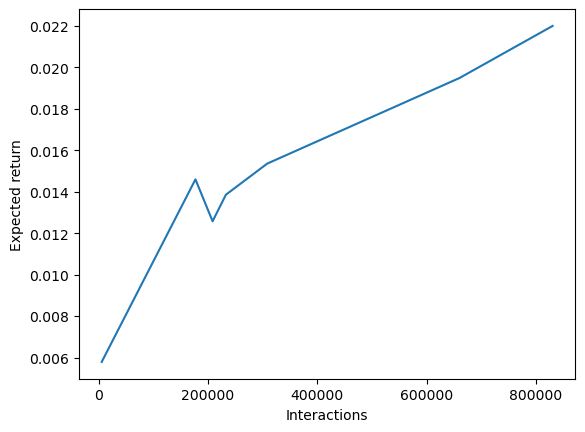

In [73]:
import matplotlib.pyplot as plt

interactions_rand = interactions_tot
vals_rand = vals
Q_rand = Q

plt.plot(interactions_rand,vals_rand)
plt.xlabel('Interactions')
plt.ylabel('Expected return')
plt.show()

## SARSA (on-policy TD controller)

<div><img src="pictures/SuttonBook_SARSA.png" width=600></div>


Test SARSA on the same environment as the previous brute force.

In [74]:
iters = 40000
interactions_tot = []
vals = []
Q = np.zeros((env.observation_space.n, env.action_space.n))
epsilon = 0.1
gamma = 0.9
alpha = 0.1
plot_ind = 0

interactions = 0

for ind, it in enumerate(range(iters)):
    s_t, info = env.reset()
    if np.random.random(1) < epsilon:
        a_t = np.random.randint(env.action_space.n)
    else:
        a_t = np.argmax(Q[s_t,:])
    while True:
        s_t_new, r_t, done, truncated, info = env.step(a_t) 
        interactions += 1
        
        if np.random.random(1) < epsilon:
            a_t_new = np.random.randint(env.action_space.n)
        else:
            a_t_new = np.argmax(Q[s_t_new,:])

        Q[s_t,a_t] = Q[s_t,a_t]+alpha*(r_t+gamma*Q[s_t_new,a_t_new]-Q[s_t,a_t])
        s_t = s_t_new
        a_t = a_t_new

        if done:
            break
    if np.random.random(1) < 0.0005 or plot_ind == 0:
        pi_Q = np.argmax(Q,axis=1)
        val_mean, val_min, val_max, val_std, _ = eval_policy(env,pi_Q,0.9, 1000, 1000, False)
        vals.append(val_mean)
        print(val_mean)
        interactions_tot.append(interactions)
        plot_ind += 1
env.close()    

0.0
0.0
0.0
0.0
0.0
0.06687673346047086
0.06825909296046598
0.06501991082760658
0.04023915478512014
0.06488023998206592
0.04806159914134513
0.05042816673253504
0.07008789748721432
0.060830901949737635
0.04119082549636967
0.05544609543288243
0.05769717391031305
0.0649726971234505
0.06681552836180948
0.058603940382606294


Compare performance of SARSA vs Brute force

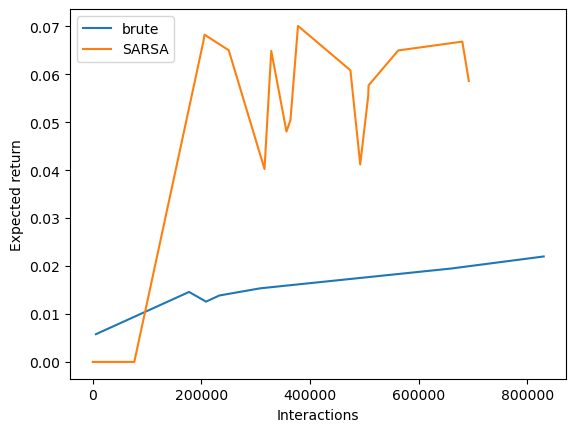

In [75]:
interactions_sarsa = interactions_tot
vals_sarsa = vals
Q_sarsa = Q
plt.plot(interactions_rand,vals_rand,label='brute')
plt.plot(interactions_sarsa,vals_sarsa,label='SARSA')
plt.xlabel('Interactions')
plt.ylabel('Expected return')
plt.legend()
plt.show()

## Q-learning (off-policy TD learning)

Instead of selecting actions according to its sampling policy, Q-learning directly uses the optimal policy rule.

<div><img src="pictures/SuttonBook_Q-learning.png" width=600></div>

In [ ]:
Run Q-learning (note similarity to SARSA)

In [76]:
iters = 40000
interactions_tot = []
vals = []
Q = np.zeros((env.observation_space.n, env.action_space.n))
epsilon = 0.1
gamma = 0.9
alpha = 0.1
plot_ind = 0

interactions = 0

for ind, it in enumerate(range(iters)):
    s_t, info = env.reset()
    while True:
        if np.random.random(1) < epsilon:
            a_t = np.random.randint(env.action_space.n)
        else:
            a_t = np.argmax(Q[s_t_new,:])

        s_t_new, r_t, done, truncated, info = env.step(a_t) 
        interactions += 1
        

        Q[s_t,a_t] = Q[s_t,a_t]+alpha*(r_t+gamma*np.max(Q[s_t_new,:])-Q[s_t,a_t])
        s_t = s_t_new

        if done:
            break
    if np.random.random(1) < 0.0005 or plot_ind == 0:
        pi_Q = np.argmax(Q,axis=1)
        val_mean, val_min, val_max, val_std, _ = eval_policy(env,pi_Q,0.9, 1000, 1000, False)
        vals.append(val_mean)
        print(val_mean)
        interactions_tot.append(interactions)
        plot_ind += 1
env.close()    

0.0
0.0
0.046304948001516265
0.055165751309890806
0.06609165228350293
0.05804902079702395
0.047792710787057865
0.07086778093657983
0.0706613707740726
0.02634589699624754
0.051063753607357314
0.0551829974600928
0.0487891793509417
0.07198593768089181
0.04045575289226113
0.06540324349553893
0.0582948240710524
0.06750508982499645
0.06343105562349341
0.0598990418137827
0.058087617057556384
0.04204798301226321
0.05617567288419129
0.025023915773439858


Again compare all three learning methods.

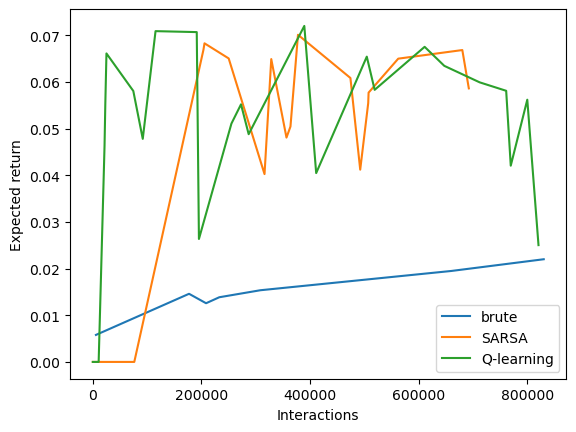

In [77]:
interactions_qlearn = interactions_tot
vals_qlearn = vals
Q_learn = Q
plt.plot(interactions_rand,vals_rand,label='brute')
plt.plot(interactions_sarsa,vals_sarsa,label='SARSA')
plt.plot(interactions_qlearn,vals_qlearn,label='Q-learning')
plt.xlabel('Interactions')
plt.ylabel('Expected return')
plt.legend()
plt.show()

### On-policy vs. off-policy

#### Example: CliffWalking

<div>
    <img src="pictures/Gymnasium_CliffWalking.png" width=600>
</div>



In [78]:
env = gym.make('CliffWalking-v0', render_mode="ansi")
#env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="ansi")
env.reset()
print(env.render())

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T




**Brute force**

In [79]:
rand_iters = 20
interactions_tot = [] #np.empty(rand_iters)
vals = [] #np.empty(rand_iters)
best_mean = -1000

plot_ind = 0
interactions_acc = 0

for ind, it in enumerate(range(rand_iters)):
    Q = np.random.uniform(low=0.0, high=1.0, size=(env.observation_space.n, env.action_space.n))
    pi_Q = np.argmax(Q,axis=1)
    val_mean, val_min, val_max, val_std, interactions = eval_policy(env,pi_Q,0.9, 50, 100, False)
    interactions_acc += interactions

    if val_mean > best_mean:
        best_mean = val_mean
        best_Q = Q

    if np.random.random(1) < 0.5 or plot_ind == 0:
        pi_Q = np.argmax(best_Q,axis=1)
        val_mean, val_min, val_max, val_std, interactions = eval_policy(env,pi_Q,0.9, 50, 100, False)
        vals.append(val_mean) # vals[plot_ind] = val_mean
        print(val_mean)
        interactions_tot.append(interactions_acc)
        #interactions_tot[plot_ind] = interactions_acc
        plot_ind += 1

-994.8462247926799
-994.8462247926799
-9.948462247926798
-9.948462247926798
-9.948462247926798
-9.948462247926798
-9.948462247926798
-9.948462247926798
-9.948462247926798
-9.948462247926798


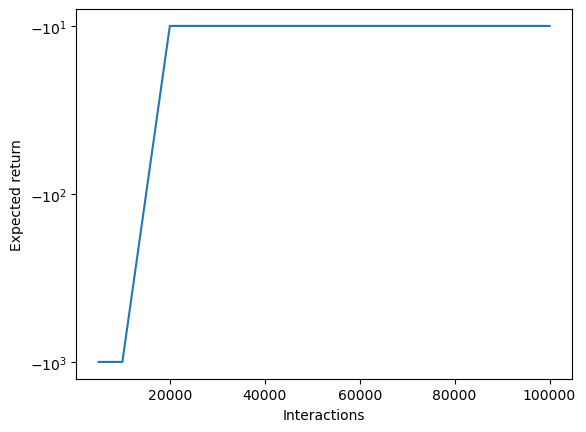

In [80]:
interactions_rand = interactions_tot
vals_rand = vals
Q_rand = Q

plt.plot(interactions_rand,vals_rand)
plt.xlabel('Interactions')
plt.ylabel('Expected return')
plt.yscale('symlog')
plt.show()

**SARSA**

In [81]:
iters = 4000
interactions_tot = []
vals = []
Q = np.zeros((env.observation_space.n, env.action_space.n))
epsilon = 0.1
gamma = 0.9
alpha = 0.1
plot_ind = 0

interactions = 0

for ind, it in enumerate(range(iters)):
    s_t, info = env.reset()
    if np.random.random(1) < epsilon:
        a_t = np.random.randint(env.action_space.n)
    else:
        a_t = np.argmax(Q[s_t,:])
    while True:
        s_t_new, r_t, done, truncated, info = env.step(a_t) 
        interactions += 1
        
        if np.random.random(1) < epsilon:
            a_t_new = np.random.randint(env.action_space.n)
        else:
            a_t_new = np.argmax(Q[s_t_new,:])

        Q[s_t,a_t] = Q[s_t,a_t]+alpha*(r_t+gamma*Q[s_t_new,a_t_new]-Q[s_t,a_t])
        s_t = s_t_new
        a_t = a_t_new

        if done:
            break
    if np.random.random(1) < 0.005 or plot_ind == 0:
        pi_Q = np.argmax(Q,axis=1)
        val_mean, val_min, val_max, val_std, _ = eval_policy(env,pi_Q,0.9, 50, 100, False)
        vals.append(val_mean)
        print(val_mean)
        interactions_tot.append(interactions)
        plot_ind += 1
env.close()    

-994.8462247926799
-9.948462247926798
-9.948462247926798
-9.948462247926798
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-7.941088679053511
-7.941088679053511
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-7.941088679053511
-7.941088679053511
-7.941088679053511
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334
-8.33228183003334


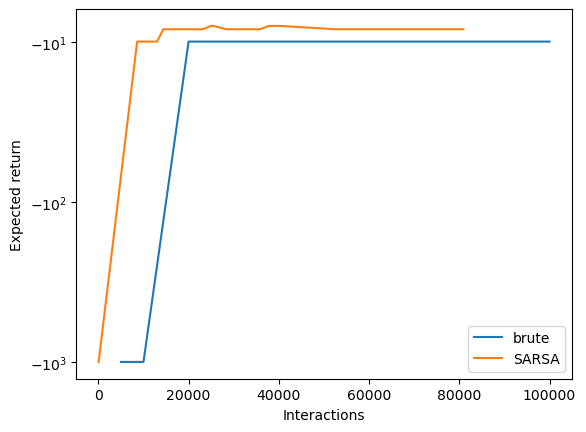

In [82]:
interactions_sarsa = interactions_tot
vals_sarsa = vals
Q_sarsa = Q
plt.plot(interactions_rand,vals_rand,label='brute')
plt.plot(interactions_sarsa,vals_sarsa,label='SARSA')
plt.xlabel('Interactions')
plt.ylabel('Expected return')
plt.yscale('symlog')
plt.legend()
plt.show()

**Q-learning**

In [83]:
iters = 4000
interactions_tot = []
vals = []
Q = np.zeros((env.observation_space.n, env.action_space.n))
epsilon = 0.1
gamma = 0.9
alpha = 0.1
plot_ind = 0

interactions = 0

for ind, it in enumerate(range(iters)):
    s_t, info = env.reset()
    if np.random.random(1) < epsilon:
        a_t = np.random.randint(env.action_space.n)
    else:
        a_t = np.argmax(Q[s_t,:])
    while True:
        s_t_new, r_t, done, truncated, info = env.step(a_t) 
        interactions += 1
        
        if np.random.random(1) < epsilon:
            a_t_new = np.random.randint(env.action_space.n)
        else:
            a_t_new = np.argmax(Q[s_t_new,:])

        Q[s_t,a_t] = Q[s_t,a_t]+alpha*(r_t+gamma*np.max(Q[s_t_new,:])-Q[s_t,a_t])
        s_t = s_t_new
        a_t = a_t_new

        if done:
            break
    if np.random.random(1) < 0.005 or plot_ind == 0:
        pi_Q = np.argmax(Q,axis=1)
        val_mean, val_min, val_max, val_std, _ = eval_policy(env,pi_Q,0.9, 50, 100, False)
        vals.append(val_mean)
        print(val_mean)
        interactions_tot.append(interactions)
        plot_ind += 1
env.close()    

-994.8462247926799
-9.948462247926798
-9.948462247926798
-8.33228183003334
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995
-7.4581341716709995


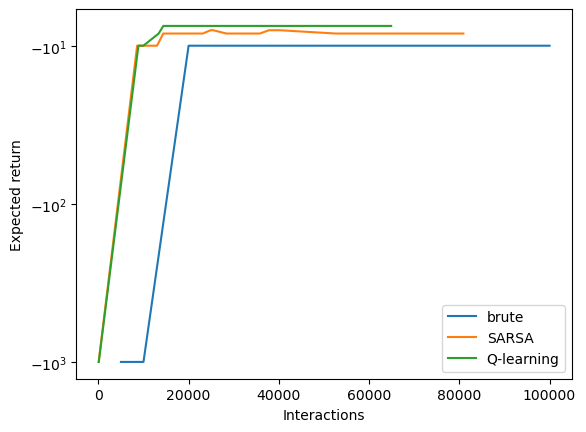

In [84]:
interactions_qlearn = interactions_tot
vals_qlearn = vals
Q_learn = Q
plt.plot(interactions_rand,vals_rand,label='brute')
plt.plot(interactions_sarsa,vals_sarsa,label='SARSA')
plt.plot(interactions_qlearn,vals_qlearn,label='Q-learning')
plt.xlabel('Interactions')
plt.ylabel('Expected return')
plt.yscale('symlog')
plt.legend()
plt.show()

The environment is deterministic, but different methods seem to converge to slightly different solutions so let's compare them visually. Comment out one of the pi functions.

In [86]:
import time

s, info = env.reset()
print(env.render())

#pi = np.argmax(Q_rand,axis=1)
#pi = np.argmax(Q_learn,axis=1)
pi = np.argmax(Q_sarsa,axis=1)

gamma = 0.9

G = 0
discount = 1
while True:
    time.sleep(1)
    a = pi[s]
    s, reward, terminated, truncated, info = env.step(a)
    print(env.render())
    G = G+discount*reward
    discount = gamma*discount
    if terminated:
        break
print(G)

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  o  o  o  o  o  o  o  o  o
x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


x  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  x  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  x  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  o  x  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  T


o  o  

## References

 * R.S. Sutton and A.G. Barto (2021): Reinforcement Learning: An Introduction. 2n ed. URL: http://incompleteideas.net/book/the-book.html 
